## This notebook is meant to outline how the BatAnalysis Tool can be used alongside swifttools to query, download, and analyze BAT GUANO data. 

Here, we will be querying for BAT GUANO data that was triggered by an FRB. We filter out the data to select one where FRB 180916.J0158+65 is in the BAT FOV. Then, we use the BatAnalysis Tools to look at the lightcurve and produce flux upper limits for the FRB in the 15-150 keV range. 

Additional information on the BAT GUANO system can be found here: [https://arxiv.org/pdf/2005.01751](https://arxiv.org/pdf/2005.01751) and here: [https://www.swift.psu.edu/guano/](https://www.swift.psu.edu/guano/)


In [3]:
import batanalysis as ba
from swifttools.swift_too import GUANO, ObsQuery
import swiftbat

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
import datetime
import os


In [5]:
object_name = "FRB 180916.J0158+65"

object_location = swiftbat.simbadlocation(object_name)
object_location=SkyCoord(ra=object_location[0]*u.deg, dec=object_location[1]*u.deg)

object_batsource = swiftbat.source(
    ra=object_location.ra.deg, dec=object_location.dec.deg, name=object_name
)


In [17]:
guano=GUANO(triggertype="FRB", limit=300)
query=ObsQuery(obsid=[i.obsid for i in guano])

In [18]:
exposures = np.array(
    [object_batsource.exposure(ra=i.ra,
                               dec=i.dec, 
                               roll=i.roll)[0]
        for i in query
    ])
print(exposures)

[   0.            0.            0.            0.            0.
    0.         1927.77407848    0.            0.            0.
    0.            0.            0.            0.            0.
    0.         3849.10512206    0.            0.            0.
 1630.52352848 1627.52601488    0.         1128.67083846    0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.         1158.46924368
 1022.08410054 4363.9596     4363.9596     4363.9596     4363.9596
 4363.9596     4363.9596        0.            0.            0.
    0.            0.            0.            0.            0.
 2083.81141035    0.            0.            0.            0.
    0.            0.            0.          292.93074499  352.18562601
  757.60837802 3533.95902229    0.            0.            0.
    0.            0.            0.            0.          707.18067393
    0.            0.            0.            0.            0.
    0.            0.       

In [43]:
minexposure = 1000  # cm^2 after cos adjust
sel_guano=np.array(query)[np.where(exposures > minexposure)[0]][0]
triggertime=guano[int(np.where([int(sel_guano.obsid)==int(i.obsid) for i in guano])[0])].triggertime
print(sel_guano)

Rejected with the following error(s): Failed to decode JSON. Please check that your shared secret is correct.


In [25]:
tmp_download_dir="/tmp/batdata/download_examples"

ba.datadir(tmp_download_dir, mkdir=True)

download = ba.download_swiftdata(observations=sel_guano.obsid)

print(download)

{'00041554004': {'obsid': '00041554004', 'success': True, 'obsoutdir': PosixPath('/private/tmp/batdata/download_examples/00041554004'), 'quicklook': False, 'data': Swift_Data(username='anonymous',obsid='00041554004',quicklook='False',auxil='True',bat='True',xrt='False',uvot='False',log='False',tdrss='True')}}


In [29]:
event=ba.BatEvent(sel_guano.obsid, is_guano=True)

/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/bat_tte.py:273: UserWarning: Since this is a GUANO dataset the RA/Dec coordinates may not be valid. These are currently being set to(358.00961064659 deg, 17.7879537534894 deg). Please verify that these are correct for your analysis.


A save file has been written to /private/tmp/batdata/download_examples/00041554004_eventresult/batevent.pickle.


In [30]:
event.apply_mask_weighting(ra=object_location.ra, dec=object_location.dec)

In [ ]:
lc=event.create_lightcurve()

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='MET (s)', ylabel='RATE (ct / s)'>)

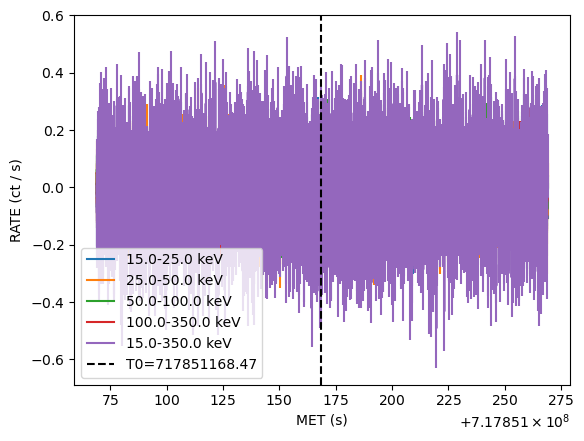

In [45]:
lc.plot(T0=triggertime.met)

In [46]:
lc.set_energybins(emin=15*u.keV, emax=350*u.keV)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='MET (s)', ylabel='RATE (ct / s)'>)

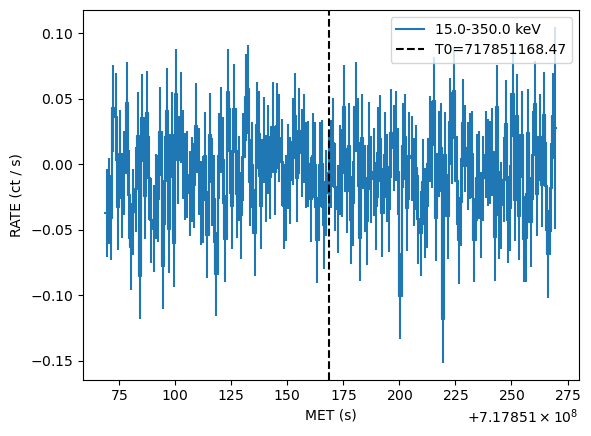

In [51]:
lc.set_timebins(timebinalg="uniform", timedelta=np.timedelta64(1, 's'))
lc.plot(T0=triggertime.met)

In [53]:
spectrum=event.create_pha(tstart=-5*u.s, tstop=5*u.s, is_relative=True, T0=triggertime.met)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='E (keV)', ylabel='Count Rate (ct/s)'>)

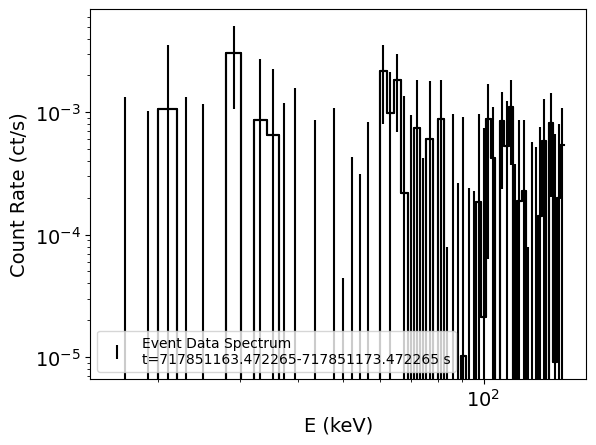

In [54]:
spectrum.plot()

In [61]:
ba.fit_spectrum(spectrum)


ERROR: Mismatch in the CFITSIO_SONAME value in the fitsio.h include file
that was used to build the CFITSIO library, and the value in the include file
that was used when compiling the application program:
   Version used to build the CFITSIO library   = 9
   Version included by the application program = 10

Fix this by recompiling and then relinking this application program 
with the CFITSIO library.

ERROR: Mismatch in the CFITSIO_SONAME value in the fitsio.h include file
that was used to build the CFITSIO library, and the value in the include file
that was used when compiling the application program:
   Version used to build the CFITSIO library   = 9
   Version included by the application program = 10

Fix this by recompiling and then relinking this application program 
with the CFITSIO library.
New filename ( "none" or "/*" to return to the XSPEC prompt): No such file: .pha
New filename ( "none" or "/*" to return to the XSPEC prompt): No such file: .pha
New filename ( "none" or "/*

Error: cannot read spectrum file t_717851163.472265-717851173.472265_80chan.pha
terminated at user request


ValueError: PyCapsule_New called with null pointer

In [60]:
upperlim_spect=ba.calculate_detection(spectrum)

ValueError: The spectrum has not been fitted with a model. A detection cannot be determined until a modelhas been fit to the spectrum and the spectral_model attribute has a model saved.

In [59]:
%debug


> /Users/tparsota/HEASOFT/heasoft-6.33.2/x86_64-apple-darwin23.5.0/lib/python/xspec/spectrum.py(198)__init__()
    196             self.__handle = dataFile
    197         else:
--> 198             self.__handle = _pyXspec.readSpectrum(dataFile)
    199         self.__detArray = _DetArrayEmulator(self.__handle)
    200         specIdx = _pyXspec.getIndexFromHandle(self.__handle)

ipdb> up
> /Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/batlib.py(1012)fit_TTE_spectrum()
   1010 
   1011     xsp.AllData -= "*"
-> 1012     s = xsp.Spectrum(
   1013         pha_file
   1014     )

ipdb> pha_file
't_717851163.472265-717851173.472265_80chan.pha'
ipdb> pha_dir
PosixPath('/private/tmp/batdata/download_examples/00041554004_eventresult/pha')
ipdb> Path.cwd()
PosixPath('/private/tmp/batdata/download_examples/00041554004_eventresult/pha')
ipdb> list(Path.cwd().glob("*"))
*** Error in argument: '(Path.cwd().glob("*"))'
ipdb> !ls
*** NameError: name 'ls' is not defined
ipdb> P